# Cross Entropy Method for Sampling in Risk-Averse RL

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gym
import GuardedMaze
import GuardedMazeLab as GML
import Agents
import utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

### The Guarded Maze benchmark

A sample episode of a random agent:

Return: -32


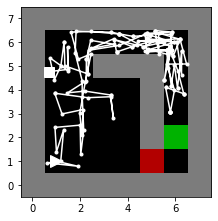

In [2]:
# Make sure the environment is registered
if 'GuardedMazeEnv-v0' in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs['GuardedMazeEnv-v0']
gym.envs.registration.register(id='GuardedMazeEnv-v0', entry_point='GuardedMaze:GuardedMaze')

# Load env
env = gym.make('GuardedMazeEnv-v0')
env.reset(init_state=(1,1))

# Run episode (with random actions)
done = False
while not done:
    obs, r, done, info = env.step(env.action_space.sample())

# Summarize episode
print('Return:', info['r'])
env._show_state()
env.close()

### CE for risk-averse RL on the Guarded Maze

Bernoulli-distributed guard-presence in the guarded zone ($\phi_1=20\%$); exponentially-distributed guard-cost (with average $\phi_2=$ twice the goal reward); 
CVaR optimization in this case is with respect to the Bernoulli and Exponential distributions parameterized by $\phi$.

Training 5/5 remaining agents...
Training 5 agents...
Waiting for trainings...
Waiting for processes...
Done.	(8090s)
Waiting for tests...
Waiting for processes...
Done.	(81s)
PG:	mean=4.2	CVaR10=-40.3	CVaR05=-63.3
GCVaR:	mean=-32.0	CVaR10=-32.0	CVaR05=-32.0
CE_GCVaR:	mean=-32.0	CVaR10=-32.0	CVaR05=-32.0
SGCVaR:	mean=-25.5	CVaR10=-33.8	CVaR05=-35.6
CE_SGCVaR:	mean=1.9	CVaR10=-4.5	CVaR05=-6.5
CPU times: user 1min 44s, sys: 2.28 s, total: 1min 46s
Wall time: 2h 17min 36s


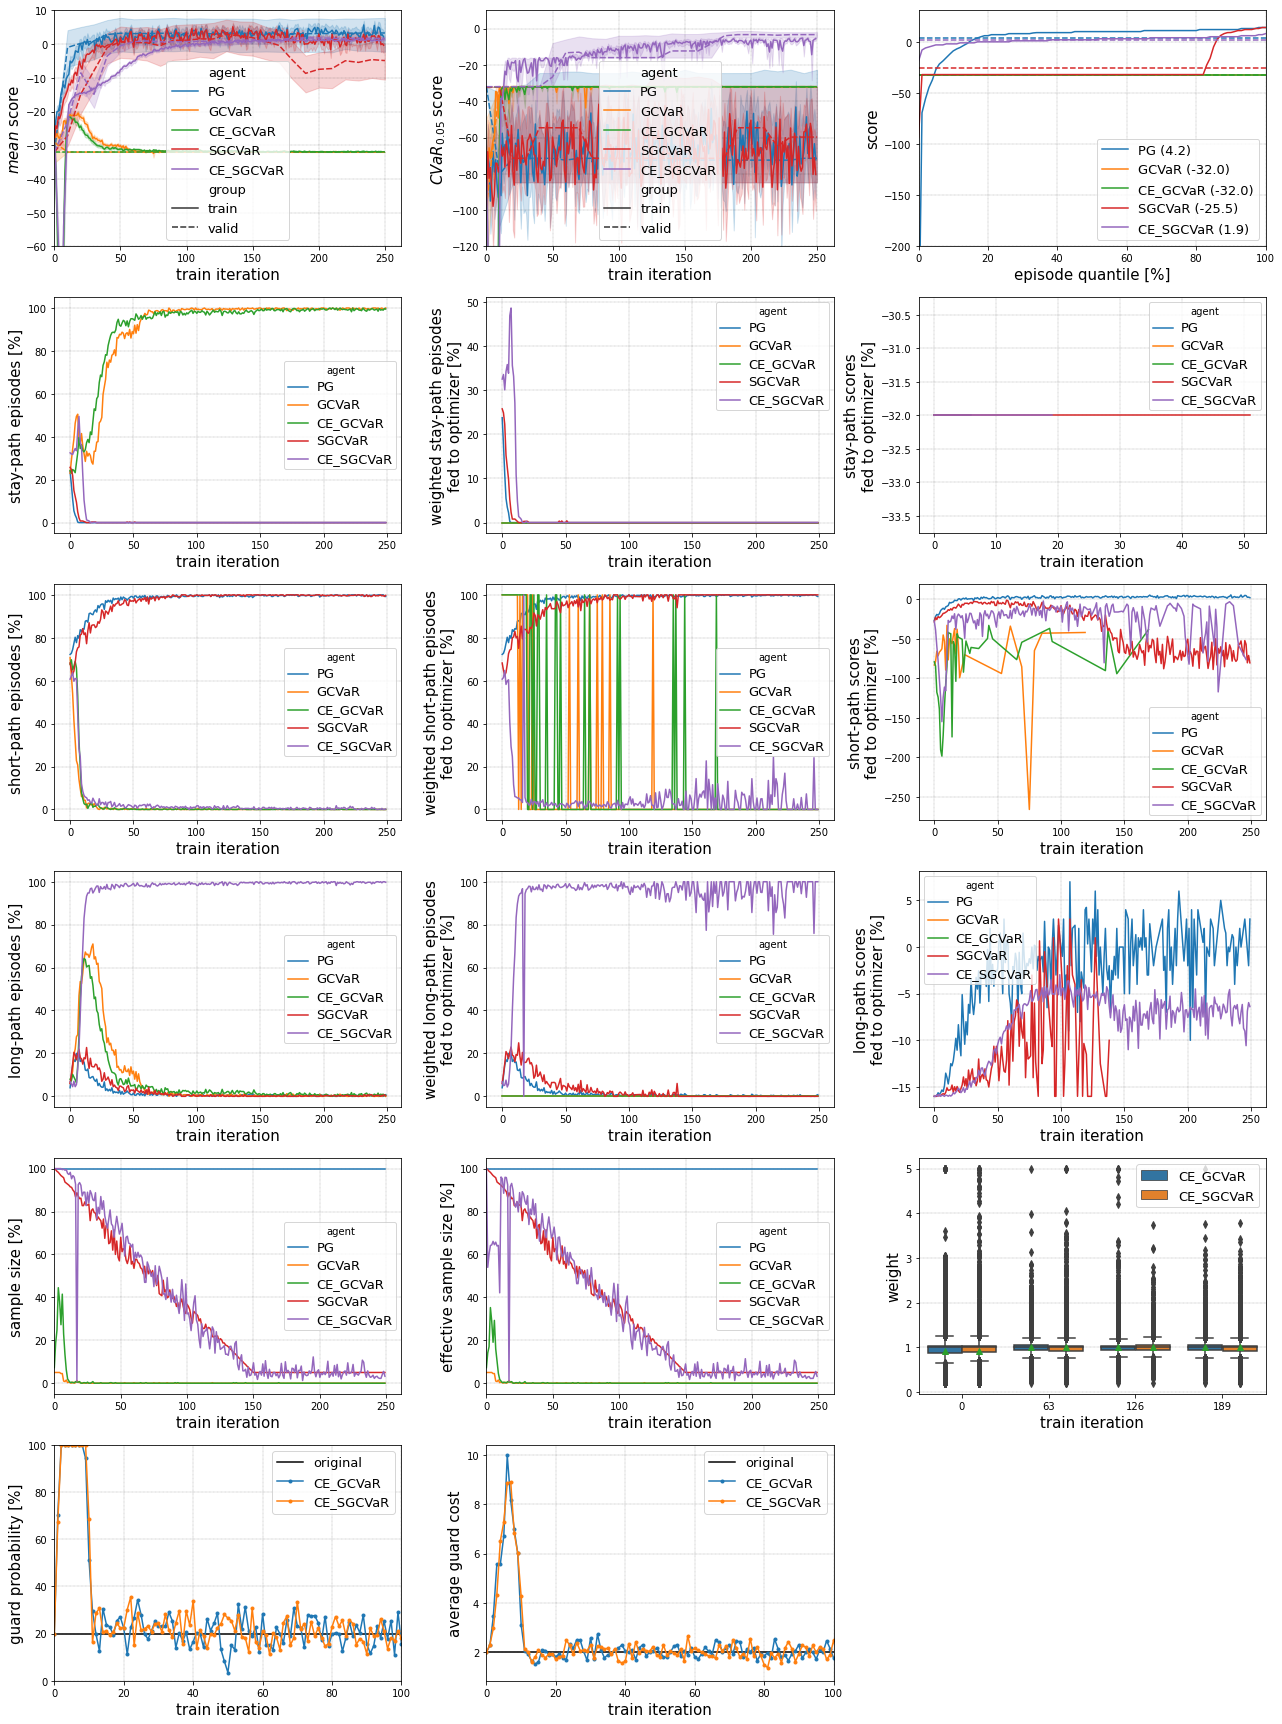

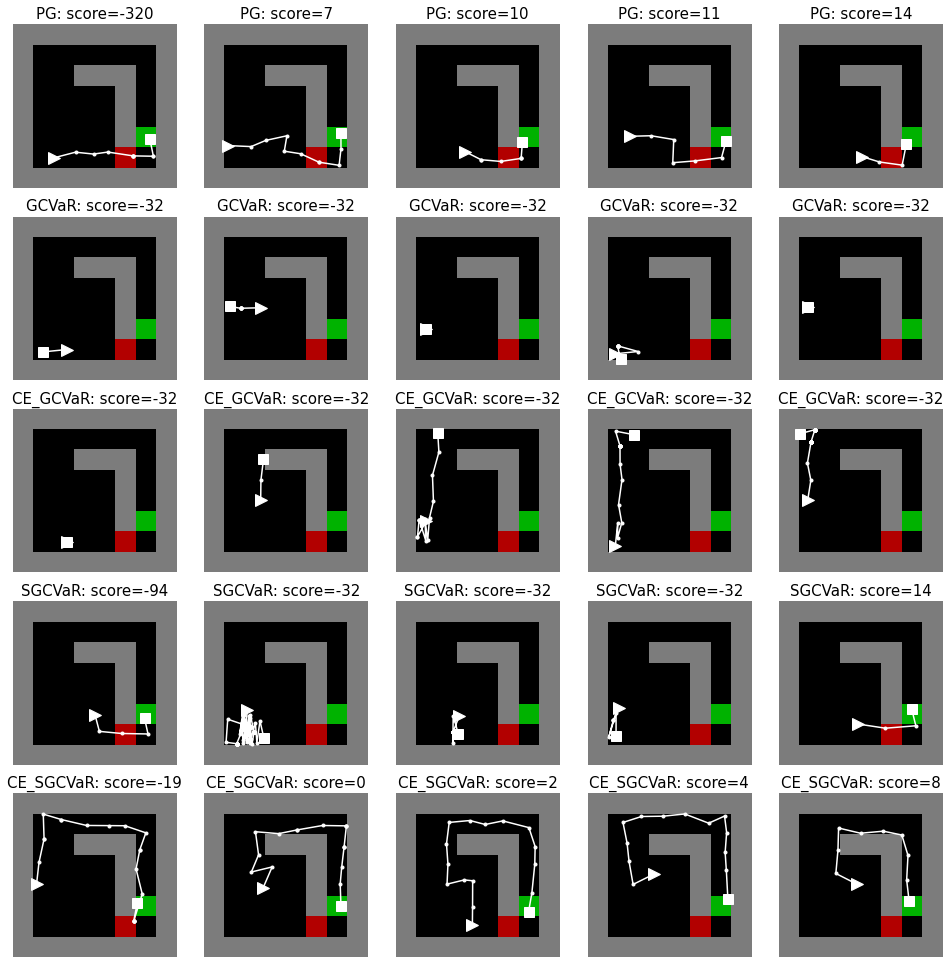

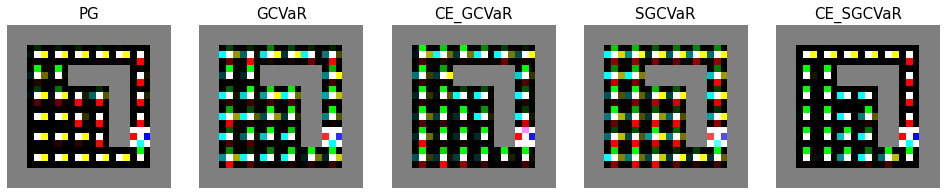

In [3]:
%%time

experiment_args = dict(guard_prob=0.2, guard_cost=2, rand_cost=True, title='maze_randcost')

# Define agents (note that the training hyperparams are also defined here through the dict train_hparams).
agents = dict(
    PG = (Agents.FC, dict()),
    GCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05))),
    CE_GCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, ce_update_freq=1))),  # + CE
    SGCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, soft_cvar=0.6))),  # + soft-CVaR
    CE_SGCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, ce_update_freq=1, soft_cvar=0.6))),  # + CE + soft-CVaR
);

# Run experiment: setup, training, testing and analysis.
E2 = GML.Experiment(agents, train_episodes=100000, valid_episodes=60, test_episodes=1000, optim_freq=400,
                    no_change_tolerance=0, **experiment_args)
axs = E2.main()

# Save results and show a sample of episodes.
E2.save_results()

axs[0].set_ylim((max(axs[0].get_ylim()[0],-60),10))
axs[1].set_ylim((max(axs[1].get_ylim()[0],-120),10))
axs[2].set_ylim((max(axs[2].get_ylim()[0],-200),None))
axs[2].legend(fontsize=13, loc='lower right')
axs[0].legend(fontsize=13, loc='lower center')
axs[1].legend(fontsize=13, loc='lower center')
axs[2].legend(fontsize=13, loc='lower right')
axs[15].set_xlim((0,100))
axs[16].set_xlim((0,100))
plt.savefig(f'outputs/{experiment_args["title"]}_summary.png', bbox_inches='tight')

E2.show_tests()
plt.savefig(f'outputs/{experiment_args["title"]}_examples.png', bbox_inches='tight')

E2.visualize_policies()
plt.savefig(f'outputs/{experiment_args["title"]}_policies.png', bbox_inches='tight')

### Optimizer analysis

Long-path episodes per batch (a) in total; (b) among the episodes fed to the optimizer, with weights taken into account.
Only first 100 iterations are shown for clarity.
For GCVaR and CE-GCVaR, the long-path episodes never make it into the bottom 5% of the batch, hence are not fed to the optimizer and cannot be learned. Their percent increases in the beginning as a side-effect of the short-path avoidance, but they are never explicitly encouraged and thus decay over time in favour of the stay-path.
For SGCVaR, the long-path episodes are fed to the optimizer but are considered worse than the short-path, thus learned to be entirely avoided by the time the soft-$\alpha$ reaches its low target level.
Only for CE-SGCVaR, the long-path episodes are both visible and considered a positive example to be learned.

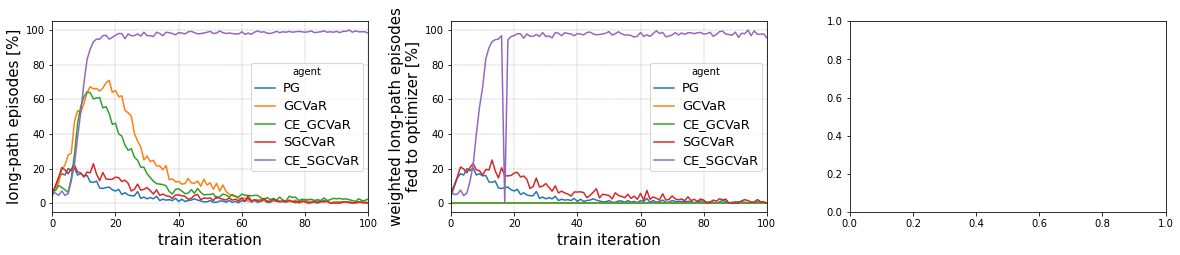

In [4]:
o = pd.concat([E2.optimizers[ag].get_data()[1] for ag in E2.agents_names])
o['agent'] = o.title
axs = E2.analyze_exposure(o, E2.agents_names, track='long')
for a in range(3):
    axs[a].set_xlim((0,100))
axs[2].clear()
plt.tight_layout()
plt.savefig(f'outputs/{experiment_args["title"]}_longs.png', bbox_inches='tight');

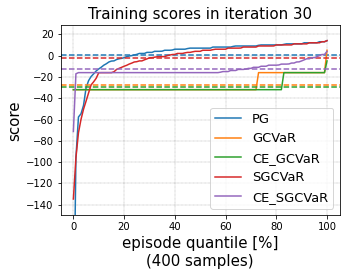

In [5]:
it = 30
ax = utils.qplot(E2.dd[E2.dd.ag_updates==it], 'score', 'episode', 'agent');
ax.set_title(f'Training scores in iteration {it}', fontsize=15);
ax.set_ylim((-150,None));
plt.savefig(f'outputs/{experiment_args["title"]}_train_scores.png', bbox_inches='tight');

### CE distribution analysis

The average and CVaR returns of the CE-GCVaR agent during the training, over episodes whose configurations were drawn from (1) the original distribution, and (2) the CE sample distribution.
Only first 60 iterations are shown for clarity.
In the beginning, the CE sample distribution learns the difficult conditions, such that its mean quickly follows the original distribution's CVaR.
Later, as the agent learns to perform robustly and independently of the conditions (by taking the long path), the sample distribution aligns with the original distribution (in both mean and CVaR).

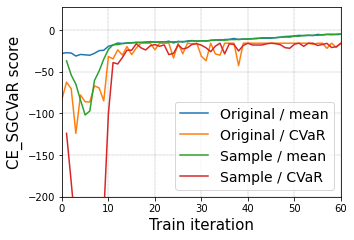

In [6]:
agent_name = 'CE_SGCVaR'

cvar = lambda x, alpha: np.mean(np.sort(x)[:int(np.ceil(alpha*len(x)))])

c1, c2 = E2.CEs[agent_name].get_data()
c2['orig'] = c2.weight==1
mean_orig = c2[c2.orig].groupby('batch').apply(lambda d: d.score.mean())
cvar_orig = c2[c2.orig].groupby('batch').apply(lambda d: cvar(d.score.values,0.05))
mean_samp = c2[~c2.orig].groupby('batch').apply(lambda d: d.score.mean())
cvar_samp = c2[~c2.orig].groupby('batch').apply(lambda d: cvar(d.score.values,0.05))

ax = utils.Axes(1,1)[0]
ax.plot(mean_orig, label='Original / mean')
ax.plot(cvar_orig, label='Original / CVaR')
ax.plot(mean_samp, label='Sample / mean')
ax.plot(cvar_samp, label='Sample / CVaR')
ax.set_xlim((0,60))
ax.set_ylim((-200, None))
utils.labels(ax, 'Train iteration', f'{agent_name} score', fontsize=15)
ax.legend(fontsize=14);
plt.savefig(f'outputs/{experiment_args["title"]}_CE.png', bbox_inches='tight');